c:\Users\Trevo\anaconda3\envs\genAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-22 17:06:39,217	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-22 17:06:39,413	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, 

   unique_id       ARIMA unique_id                  ds      NBEATS       NHITS
0         GM  366.890171        GM 2025-04-23 05:00:00  368.210602  367.697662
1         GM  363.184333        GM 2025-04-24 05:00:00  364.153229  363.881622
2         GM  357.966893        GM 2025-04-25 05:00:00  358.703949  358.571350
3         GM  350.340128        GM 2025-04-26 05:00:00  350.276215  351.471008
4         GM  343.500057        GM 2025-04-27 05:00:00  340.144531  342.332245
5         GM  335.412793        GM 2025-04-28 05:00:00  337.247345  337.222107
6         GM  326.622948        GM 2025-04-29 05:00:00  329.969330  329.378906
7         GM  319.248082        GM 2025-04-30 05:00:00  322.199127  322.308899
8         GM  311.388890        GM 2025-05-01 05:00:00  313.071503  314.381073
9         GM  304.373117        GM 2025-05-02 05:00:00  306.454529  307.425842
10        GM  299.194251        GM 2025-05-03 05:00:00  305.711426  305.342377
11        GM  294.348580        GM 2025-05-04 05:00:

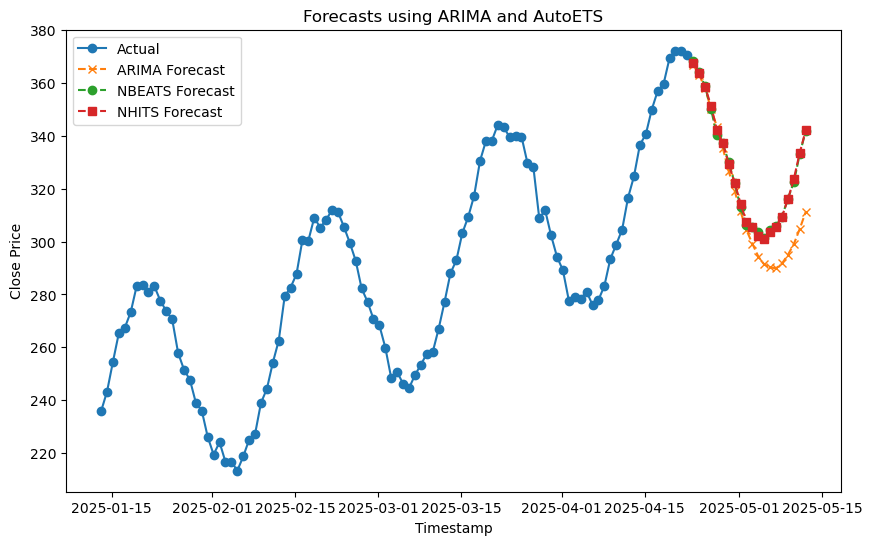

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

from _functions import get_arima_predictions

# Dummy get_stock_data function returning sample data
def get_stock_data(ticker: str) -> pd.DataFrame:
    np.random.seed(42)  # For reproducibility
    data = {
        'open': [233.530 + i for i in range(100)],
        'high': [234.67 + i for i in range(100)],
        'low': [229.720 + i for i in range(100)],
        'close': [234.40 + i + np.random.randn() * 3 + 40 * np.sin(2 * np.pi * i / 30) for i in range(100)],  # Added seasonality
        'volume': [45530515.0 + i * 1000 for i in range(100)],
        'vwap': [232.6052 + i for i in range(100)],
        'timestamp': [1736744400000 + i * 86400000 for i in range(100)],  # Increment by 1 day in milliseconds
        'transactions': [561138 + i * 100 for i in range(100)],
        'otc': [None for _ in range(100)]
    }
    return pd.DataFrame(data)

# Node: Fetch stock data
# THIS WORKS
def stock_data_node(state: dict) -> dict:
    """Fetches stock data for the given ticker."""
    ticker = state['ticker'][0]  # Default to the first ticker, e.g., 'GM'
    stock_data = get_stock_data(ticker=ticker)  # Use dummy get_stock_data defined above

    new_state = copy.deepcopy(state)
    new_state['data'] = stock_data  # Store the full DataFrame in state['data']
    return new_state

# Node: Forecast and plot the data
def forecast_node(state: dict) -> dict:
    """
    Generates forecasts using ARIMA and AutoETS models on the 'close' prices and plots these forecasts 
    alongside the actual data.
    
    Expects state['data'] to be a DataFrame with at least the following columns:
      - 'timestamp': Unix timestamp in milliseconds
      - 'close': observed close prices of the stock
    
    The forecast horizon is set to 10 periods. The resulting matplotlib Figure is stored in state['plot'].
    """

    # Extract and prepare data focusing on 'timestamp' and 'close'
    df = state['data'][['timestamp', 'close']].copy()
    
    # Convert timestamp from milliseconds since epoch to datetime and sort the data
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.sort_values('timestamp')
    
    # Rename columns to match statsforecast expected format: 'ds' for datetime, 'y' for the observed value
    df = df.rename(columns={'timestamp': 'ds', 'close': 'y'})
    
    # Add a unique identifier for the time series using the first ticker symbol
    df['unique_id'] = state['ticker'][0]
    
    # Set forecast horizon (e.g., 10 periods ahead)
    h = 20

    forecasts = get_arima_predictions(df, h)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the actual time series data
    ax.plot(df['ds'], df['y'], label='Actual', marker='o')
    
    # Plot the forecasted values from ARIMA and AutoETS.
    # The forecasts DataFrame is expected to include columns 'AutoARIMA' and 'AutoETS', along with 'ds'
    ax.plot(forecasts['ds'], forecasts['ARIMA'], label='ARIMA Forecast', linestyle='--', marker='x')
    ax.plot(forecasts['ds'], forecasts['NBEATS'], label='NBEATS Forecast', linestyle='--', marker='o')
    ax.plot(forecasts['ds'], forecasts['NHITS'], label='NHITS Forecast', linestyle='--', marker='s')
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Close Price')
    ax.set_title('Forecasts using ARIMA and AutoETS')
    ax.legend()

    print(forecasts)
    
    new_state = copy.deepcopy(state)
    new_state['plot'] = fig
    return new_state

# Test function to run both nodes sequentially
def test_forecasting_pipeline():
    """
    Creates a dummy state, fetches stock data, runs forecasting, and displays the resulting plot.
    """
    # Define a basic state as expected by the nodes.
    state = {
        'ticker': ['GM'],
        'data': None,
        'arts': None,
        'plot': None,
        'response': "",
        'intro': "",
        'summary': ""
    }
    
    # Run the data fetching node
    state = stock_data_node(state)
    
    # Run the forecasting node
    state = forecast_node(state)
    

test_forecasting_pipeline()


In [2]:
from neuralforecast.utils import AirPassengersDF

In [3]:
AirPassengersDF.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
